In [2]:
import torch
from transformers import pipeline

In [5]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    # torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "You are a mathematics chatbot who always responds in mathematical way!"},
    {"role": "user", "content": "what is 6 added 8?"},
]

Device set to use cuda:0


In [6]:
outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'role': 'assistant', 'content': 'A simple addition problem!\n\nTo find the answer, we simply add 6 and 8:\n\n6 + 8 = 14\n\nSo, the answer is 14!'}


### Policy Model

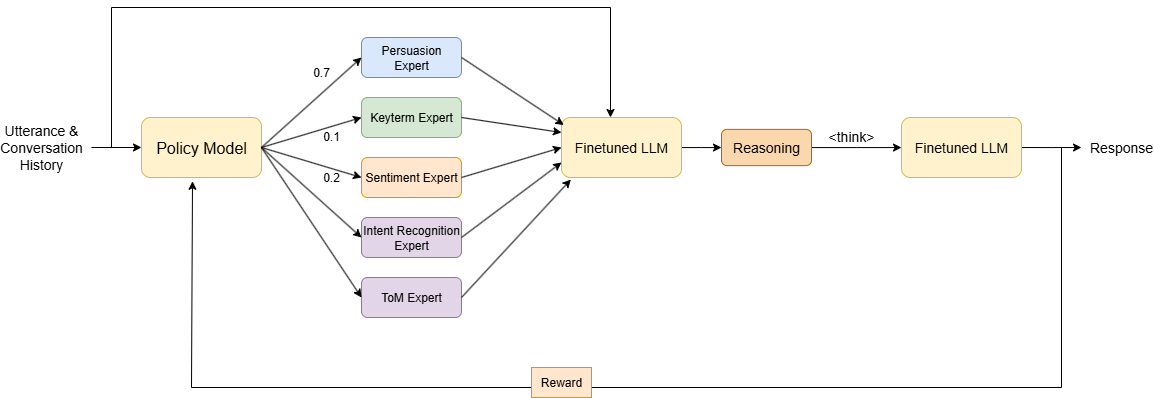

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

/DATA/rohan_kirti/miniconda3/envs/nilenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1) Define the gating model: LLaMA encoder + 5-way classifier
class LlamaExpertGating(nn.Module):
    def __init__(self, encoder: AutoModel, num_experts: int = 5):
        super().__init__()
        # use the provided encoder
        self.encoder = encoder
        hidden_size = self.encoder.config.hidden_size
        # simple linear head to score each expert
        # self.classifier = nn.Linear(hidden_size, num_experts)
        # self.classifier = nn.Sequential(
        #         nn.Linear(hidden_size, hidden_size),
        #         nn.Tanh(),
        #         nn.Linear(hidden_size, num_experts)
        #     )
        self.classifier= nn.Sequential(nn.Linear(hidden_size, num_experts))

    def forward(self, input_ids, attention_mask):
        # get last_hidden_state: (batch, seq_len, hidden)
        outputs = self.encoder(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               return_dict=True)
        # take the first token’s embedding ([CLS]-like)
        masked_output = outputs.last_hidden_state * attention_mask.unsqueeze(-1)
        pooled = masked_output.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

        # pooled = outputs.last_hidden_state[:, 0, :] # (batch, hidden)
        
        logits = self.classifier(pooled)            # (batch, 5)
        return logits

In [3]:
# 2) Your five “expert” labels
experts = ["persuasion", "keyterm", "intent", "sentiment", "tom"]

# 3) Example sentences
sentences = ["Great choice! The Tesla Model 3 is an excellent vehicle. Since you've opted for an E",
    "Absolutely. The battery is the heart of your Tesla. With Tata AI",
    "Extract the main keywords from this paragraph.",
    "What is the users intention behind this request?",
    "I am really unhappy with the service I received today.",
    "How might the character be feeling in this scene?",
    # … add your other 5 …
]

In [4]:
# 4) Load tokenizer & model
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model=AutoModel.from_pretrained(
            model_name, 
            device_map="auto",
            output_hidden_states=True, return_dict_in_generate=True,
            trust_remote_code=True
        )
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)


In [5]:
model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

In [6]:

gating_model = LlamaExpertGating(model, num_experts=len(experts))

In [7]:
sentences = [
    "I think we should focus on climate policy this election.",
    "Extract the main keywords from this paragraph.",
    "What is the user’s intention behind this request?",
    "I’m really unhappy with the service I received today.",
    "How might the character be feeling in this scene?",
    # … add your other 5 …
]
with torch.no_grad():
    for sent in sentences:
        enc = tokenizer(sent,
                        return_tensors="pt",
                        truncation=True,
                        padding=True)
        logits = gating_model(enc["input_ids"], enc["attention_mask"])
        probs = F.softmax(logits, dim=-1).cpu().tolist()[0]

        # pretty-print
        print(f"\nSentence: {sent!r}")
        for expert, p in zip(experts, probs):
            print(f"  {expert:10s}: {p:.4f}")


Sentence: 'I think we should focus on climate policy this election.'
  persuasion: 0.0724
  keyterm   : 0.5263
  intent    : 0.0676
  sentiment : 0.2865
  tom       : 0.0473

Sentence: 'Extract the main keywords from this paragraph.'
  persuasion: 0.2499
  keyterm   : 0.2846
  intent    : 0.1079
  sentiment : 0.2103
  tom       : 0.1473

Sentence: 'What is the user’s intention behind this request?'
  persuasion: 0.1128
  keyterm   : 0.3302
  intent    : 0.1283
  sentiment : 0.3186
  tom       : 0.1101

Sentence: 'I’m really unhappy with the service I received today.'
  persuasion: 0.1410
  keyterm   : 0.5506
  intent    : 0.0306
  sentiment : 0.2449
  tom       : 0.0329

Sentence: 'How might the character be feeling in this scene?'
  persuasion: 0.1623
  keyterm   : 0.3482
  intent    : 0.0602
  sentiment : 0.1906
  tom       : 0.2387


In [8]:
# Example single sentence
sentence = "I am very angry with the service I received today."
'''Assign the probabilities of each expert to the sentence. 
   The model will output a probability distribution over the experts.'''
# Tokenize and move to device
enc = tokenizer(sentence,
                return_tensors="pt",
                truncation=True,
                padding=True)

# Run model inference
with torch.no_grad():
    logits = gating_model(enc["input_ids"], enc["attention_mask"])
    probs = F.softmax(logits, dim=-1).cpu().tolist()[0]

# Print results
print(f"\nSentence: {sentence!r}")
for expert, p in zip(experts, probs):
    print(f"  {expert:10s}: {p:.4f}")



Sentence: 'I am very angry with the service I received today.'
  persuasion: 0.1575
  keyterm   : 0.5050
  intent    : 0.0435
  sentiment : 0.2456
  tom       : 0.0484


### 5 Experts

In [9]:
# Define placeholder expert modules (replace with your actual experts)
def expert_sentiment(text:str) -> str:  return f"[Sentiment applied to: {text}]"
def expert_tom(text:str) -> str:        return f"[ToM applied to: {text}]"
def expert_persuasion(text:str) -> str: return f"[Persuasion applied to: {text}]"
def expert_intent(text:str) -> str:     return f"[Intent applied to: {text}]"
def expert_keyterm(text:str) -> str:    return f"[KeyTerm applied to: {text}]"


In [10]:
experts_name = [
    expert_persuasion,  # index 0
    expert_keyterm,     # index 1
    expert_intent,      # index 2
    expert_sentiment,   # index 3
    expert_tom          # index 4
]
def apply_topk1(probability, text, k=3):
    topk_values, topk_indices = torch.topk(torch.tensor(probability).reshape(1, 5), k, dim=1)
    # Apply softmax over the top-k values
    topk_weights = F.softmax(topk_values, dim=1)  # shape: (1, k)
    mixed = []
    for idx, w in zip(topk_indices[0], topk_weights[0]):
        expert_fn = experts_name[idx.item()]
        out = expert_fn(text)
        mixed.append(f"({w.item():.2f})*" + out)
    mixed_str = " + ".join(mixed)
    print(topk_weights[0])
    return mixed_str


def apply_topk2(probability, text, k=3):
    topk_values, topk_indices = torch.topk(torch.tensor(probability).reshape(1, 5), k, dim=1)
    topk_weights = F.softmax(topk_values, dim=1)  # shape: (1, k)
    mixed = []
    for idx, w in zip(topk_indices[0], topk_weights[0]):
        expert_fn = experts_name[idx.item()]
        out = expert_fn(text)
        mixed.append(f"({w.item():.2f})*" + out)
    mixed_str = " + ".join(mixed)
    print(topk_weights)
    return mixed_str, topk_indices[0], topk_weights[0]
def apply_topk(prob_tensor, text, k=3):
    topk_values, topk_indices = torch.topk(prob_tensor, k)
    topk_weights = F.softmax(topk_values, dim=0)
    mixed = []
    for idx, w in zip(topk_indices, topk_weights):
        expert_fn = experts_name[idx.item()]
        out = expert_fn(text)
        mixed.append(f"({w.item():.2f})*" + out)
    mixed_str = " + ".join(mixed)
    return mixed_str, topk_indices, topk_weights

probs = [0.1, 0.25, 0.3, 0.2, 0.15]
probs = torch.tensor(probs)
text = "The product really impressed me!, give me discount to the product"

combine_output, top_idx, top_weights = apply_topk(probs, text)
combine_output

'(0.35)*[Intent applied to: The product really impressed me!, give me discount to the product] + (0.33)*[KeyTerm applied to: The product really impressed me!, give me discount to the product] + (0.32)*[Sentiment applied to: The product really impressed me!, give me discount to the product]'

In [11]:
probs.type

<function Tensor.type>

In [12]:
probs1 = [0.1, 0.25, 0.3, 0.2, 0.15]

probs=torch.tensor(probs1).reshape(1, 5)
probs.dim

<function Tensor.dim>

### Fine-Tuned LLM

In [13]:
# 4) Load tokenizer & model
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
finetune_model=AutoModelForCausalLM .from_pretrained(
            model_name, 
            device_map="auto",
            output_hidden_states=True, return_dict_in_generate=True,
            trust_remote_code=True
        )
finetune_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
finetune_tokenizer.pad_token = finetune_tokenizer.eos_token


In [14]:
def finetune_llm(prompt: str, model, tokenizer, max_new_tokens: int = 100) -> str:
    
    prompt +="Give more weight to the following experts as assigned by probabilities "
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate output
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_new_tokens, pad_token_id=finetune_tokenizer.eos_token_id)

    # Decode and return the response
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response
prompt= "Who are you "
finetune_llm(prompt, finetune_model, finetune_tokenizer)

'Who are you Give more weight to the following experts as assigned by probabilities 1, 2, and 3, respectively, and explain your reasoning.\nThe problem is a classic example of the problem of decision-making under uncertainty, where the decision-maker needs to make a choice between two options, A and B, and the outcome of each option is uncertain. The experts assigned probabilities 1, 2, and 3 are asked to give more weight to their opinions as follows:\n* If the probability of option A is 50%, the expert assigned probability 1 gives'

### Rewards

In [15]:
positive_words = set(["tom","sentiment","help","keyterm"])
def reward_fn(response):
    return sum(w in positive_words for w in response.lower().split()) / max(len(response.split()),1)
w=reward_fn("I am too tom keyterm love good keyterm sentiment  happy fd")
w

0.36363636363636365

### GRPO

In [16]:
def grpo_train_step(model, optimizer, inputs, m=4, top_k=3, kl_coef=0.1, clip_eps=0.1):
    # inputs: list of strings (utterances + history)
    batch_size = len(inputs)
    all_logps, all_rewards, completions = [], [], []
    
    counter=0
    
    for text in inputs:
        enc = tokenizer(text,
                return_tensors="pt",
                truncation=True,
                padding=True)
        logits = gating_model(enc["input_ids"], enc["attention_mask"])
        probs = F.softmax(logits, dim=-1).squeeze()  # Keep it as a torch.Tensor

        # probs = F.softmax(logits, dim=-1).cpu().tolist()[0]
        # probs = torch.tensor(probs)



        group_logps, group_rewards = [], []
        for _ in range(m):
            # sample top-k indices
            combined_output, top_idx, top_weights = apply_topk(probs, text)

            # Build gate vector g to compute log-prob
            # g = torch.zeros_like(torch.tensor(probs))
            g = torch.zeros_like(probs)

            g[top_idx] = top_weights
            action_logp = (g * torch.log(probs + 1e-8)).sum()

            group_logps.append(action_logp)
            # generate final response
            response = finetune_llm(combined_output, finetune_model, finetune_tokenizer)
            r = reward_fn(response) #reward function
            group_rewards.append(r)
            counter+=1
            # completions.append(text)
            # print(f"Response: {response!r}, Reward: {r:.4f}")

        # compute group baseline and advantages
        rewards = torch.tensor(group_rewards)
        logps   = torch.stack(group_logps)
        baseline = rewards.mean()
        advantages = rewards - baseline

        # compute GRPO loss
        ratios = torch.exp(logps - logps.detach())
        clipped = torch.clamp(ratios, 1-clip_eps, 1+clip_eps)
        policy_loss = -torch.min(ratios * advantages, clipped * advantages).mean()
        kl = torch.distributions.kl_divergence(
            torch.distributions.Categorical(probs),
            torch.distributions.Categorical(probs.detach())
        ).mean()
        loss = policy_loss + kl_coef * kl

        # collect for backward
        all_logps.append(loss)
        all_rewards.append(r)
        completions.append(text)

    # backprop over entire batch
    optimizer.zero_grad()
    total_loss = torch.stack(all_logps).mean()
    total_loss.backward()
    optimizer.step()
    total_reward = sum(all_rewards) / len(all_rewards)
    print("************",counter)
    return total_loss.item(), completions, all_rewards, total_reward

In [18]:
def grpo_train_step_fixed(gating_model, optimizer, inputs, tokenizer, 
                         finetune_model, finetune_tokenizer, reward_fn,
                         m=4, top_k=3, kl_coef=0.1, clip_eps=0.1):
    
    total_loss = 0.0
    all_rewards = []
    
    for text in inputs:
        # Encode input
        enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        
        # Get OLD policy probabilities (detached for comparison)
        with torch.no_grad():
            old_logits = gating_model(enc["input_ids"], enc["attention_mask"])
            old_probs = F.softmax(old_logits, dim=-1).squeeze()
        
        # Sample m actions and collect rewards
        group_rewards = []
        group_actions = []  # Store action representations
        
        for _ in range(m):
            # Add noise for exploration
            noisy_probs = old_probs + torch.randn_like(old_probs) * 0.01
            
            # Sample top-k experts
            combined_output, top_idx, top_weights = apply_topk(old_probs, text)
            
            # Store action for later probability computation
            action_vector = torch.zeros_like(old_probs)
            action_vector[top_idx] = top_weights
            group_actions.append((top_idx, top_weights))
            
            # Generate response and compute reward
            response = finetune_llm(combined_output, finetune_model, finetune_tokenizer)
            reward = reward_fn(response)
            group_rewards.append(reward)
        
        # Convert to tensors
        group_rewards = torch.tensor(group_rewards, dtype=torch.float32)
        
        # Compute advantages using group baseline
        baseline = group_rewards.mean()
        advantages = group_rewards - baseline
        
        # Now compute NEW policy probabilities (with gradients)
        new_logits = gating_model(enc["input_ids"], enc["attention_mask"])
        new_probs = F.softmax(new_logits, dim=-1).squeeze()
        
        # Compute old and new log probabilities for each action
        old_action_logprobs = []
        new_action_logprobs = []
        
        for top_idx, top_weights in group_actions:
            # Old policy log prob
            old_action_prob = (old_probs[top_idx] * top_weights).sum()
            old_action_logprobs.append(torch.log(old_action_prob + 1e-8))
            
            # New policy log prob  
            new_action_prob = (new_probs[top_idx] * top_weights).sum()
            new_action_logprobs.append(torch.log(new_action_prob + 1e-8))
        
        old_action_logprobs = torch.stack(old_action_logprobs)
        new_action_logprobs = torch.stack(new_action_logprobs)
        
        # Compute importance sampling ratios
        ratios = torch.exp(new_action_logprobs - old_action_logprobs.detach())
        
        # PPO clipped loss
        clipped_ratios = torch.clamp(ratios, 1 - clip_eps, 1 + clip_eps)
        policy_loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
        
        # KL divergence between old and new policies
        kl_div = F.kl_div(
            torch.log(new_probs + 1e-8),
            old_probs,
            reduction='sum'
        )
        
        # Total loss
        loss = policy_loss + kl_coef * kl_div
        total_loss += loss
        # print(old_action_prob)
        # print(new_action_prob)
        # Collect rewards
        all_rewards.extend(group_rewards.tolist())
    
    # Backpropagation
    optimizer.zero_grad()
    (total_loss / len(inputs)).backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(gating_model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    avg_reward = sum(all_rewards) / len(all_rewards)
    return total_loss.item() / len(inputs), avg_reward, all_rewards

In [19]:
# Your dataset
dataset = [
    "I'm feeling really down and nothing seems to be going right in my life.",
    "How can I improve my productivity and get better results at work?", 
    "What's the best way to stay motivated when facing difficult challenges?"  
]
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)

# Training loop
for epoch in range(1, 3):  # 3 epochs
    loss, avg_reward, all_rewards = grpo_train_step_fixed(
        gating_model=gating_model,
        optimizer=optimizer,
        inputs=dataset,  # Your 3 sentences
        tokenizer=tokenizer,
        finetune_model=finetune_model,
        finetune_tokenizer=finetune_tokenizer,
        reward_fn=reward_fn,
        # apply_topk=apply_topk,
        # finetune_=finetune_llm,
        m=4,         # 4 samples per sentence
        top_k=3,     # Top 3 experts
        kl_coef=0.1,
        clip_eps=0.1
    )
    
    print(f"\n\n Epoch {epoch}: Loss={loss:.4f}, Avg Reward={avg_reward:.4f}")

/DATA/rohan_kirti/miniconda3/envs/nilenv/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


OutOfMemoryError: CUDA out of memory. Tried to allocate 1002.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 32.56 MiB is free. Process 3131253 has 11.64 GiB memory in use. Including non-PyTorch memory, this process has 11.99 GiB memory in use. Of the allocated memory 11.71 GiB is allocated by PyTorch, and 35.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [24]:
dataset = [
    "I’m feeling down, and nothing’s working in my life.",
    "How can I write a better cover letter?",        
    "What’s the best way to stay motivated?"
]
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 3
import wandb
wandb.init(project="grpo-training", name="grpo_experiment_1")
table = wandb.Table(columns=["epoch", "loss", "reward", "text"], log_mode="MUTABLE")
for epoch in range(1, epochs + 1):
    loss, completions, reward, avg_reward = grpo_train_step(model, optimizer, dataset)
    print(f"\n\nEpoch {epoch}/{epochs} - Loss: {loss:.4f} - Avg Reward: {avg_reward:.4f}")

    table.add_data(epoch, loss, avg_reward, completions)
    wandb.log({'training table':table})
wandb.finish()


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rockbong225 (rockbong225-iit-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


************ 12


Epoch 1/3 - Loss: 0.0000 - Avg Reward: 0.0127
************ 12


Epoch 2/3 - Loss: -0.0000 - Avg Reward: 0.0033
************ 12


Epoch 3/3 - Loss: -0.0000 - Avg Reward: 0.0035
